# MLP Using Tensorflow

In [79]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [12]:
mnist.validation

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="validation Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

## Model 1

In [14]:
# Network Parameters
n_hidden_1 = 10 #1st hidden of 10 neurons
n_hidden_2 = 5  #2nd hidden layer of 5 neurons  
n_hidden_3 = 3  #3rd hiden layer of 3 neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [15]:
x = tf.placeholder(tf.float32, [None, 784]) # Input place holders
y_ = tf.placeholder(tf.float32, [None, 10]) # output placeholders

In [16]:
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [28]:
#initializing weights
weights_m1 = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)), # 784x10
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)),# 10x5
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.15, mean=0)),# 5x3
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0)) # 3x10
}
biases_m1 = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),            
    'out': tf.Variable(tf.random_normal([n_classes]))              
}

In [29]:
# Parameters
training_epochs = 50
learning_rate = 0.001
batch_size = 100
display_step = 1

### mlp

In [32]:
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'input layer:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, 1e-05)
    layer_1 = tf.nn.relu(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, 1e-05)
    layer_2 = tf.nn.relu(layer_2)       
    
    ''' # 3rd hidden layer
    layer_3 = tf.add(tf.matmul(layer_2,weights['h3']),biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'out:', biases['out'].get_shape())''' 
    # Output layer with Sigmoid activation
    out_layer = tf.add(tf.matmul(layer_2, weights['out']),biases['out']) # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

In [43]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_m1, biases_m1)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        validation_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_m1], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
            validation_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(validation_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),'train-validation loss curve') 

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "validation cost={:.9f}".format(validation_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:",100* accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

input layer: (?, 784) W[h1]: (784, 10) b[h1]: (10,)
layer_1: (?, 10) W[h2]: (10, 5) b[h2]: (5,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.058341488 validation cost=2.047094597
Epoch: 0002 train cost=1.769682509 validation cost=1.759185216
Epoch: 0003 train cost=1.683008502 validation cost=1.674171483
Epoch: 0004 train cost=1.644916170 validation cost=1.637619695
Epoch: 0005 train cost=1.614707451 validation cost=1.606438848
Epoch: 0006 train cost=1.591430515 validation cost=1.582609592
Epoch: 0007 train cost=1.578015844 validation cost=1.570723064
Epoch: 0008 train cost=1.570288101 validation cost=1.562967835
Epoch: 0009 train cost=1.564080526 validation cost=1.556545127
Epoch: 0010 train cost=1.559246577 validation cost=1.552447548
Epoch: 0011 train cost=1.556734112 validation cost=1.549638916
Epoch: 0012 train cost=1.552937692 validation cost=1.546841142
Epoch: 0013 train cost=1.550883962 validation cost=1.545827006
Epoch: 0014 train cost=1.549223979 validation cost=1.544394056
Epo

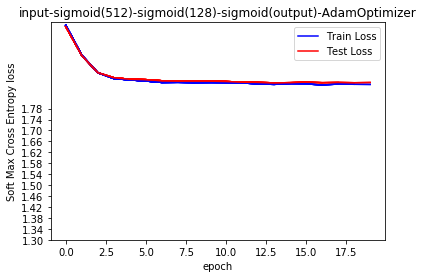

In [56]:
plt.show()

## Model 2nd

In [81]:
# Network Parameters
n_hidden_1 = 64 #1st hidden of 10 neurons
n_hidden_2 = 128  #2nd hidden layer of 5 neurons  
n_hidden_3 = 256  #3rd hiden layer of 3 neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [82]:
x = tf.placeholder(tf.float32, [None, 784]) # Input place holders
y_ = tf.placeholder(tf.float32, [None, 10]) # output placeholders

In [83]:
#initializing weights
weights_m2 = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)), # 784x10
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)),# 10x5
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.15, mean=0)),# 5x3
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0)) # 3x10
}
biases_m2 = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),            
    'out': tf.Variable(tf.random_normal([n_classes]))              
}

In [84]:
# Parameters
training_epochs = 20
learning_rate = 0.01
batch_size = 100
display_step = 1

In [85]:
def multilayer_perceptron_m2(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'input layer:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # 1st hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # 2nd hidden layer
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b3:', biases['b3'].get_shape())        
    
   
    # Output layer with Sigmoid activation
    out_layer = tf.add(tf.matmul(layer_2, weights['out']),biases['out']) # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

In [86]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron_m2(x, weights_m2, biases_m2)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        validation_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_m2], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
            validation_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(validation_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "train-validation error")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "validation cost={:.9f}".format(validation_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:",100* accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

input layer: (?, 784) W[h1]: (784, 64) b[h1]: (64,)
layer_1: (?, 64) W[h2]: (64, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 256) b3: (256,)
out_layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch: 0001 train cost=1.546658220 validation cost=1.540322604
Epoch: 0002 train cost=1.513556030 validation cost=1.511166275
Epoch: 0003 train cost=1.510580486 validation cost=1.508326968
Epoch: 0004 train cost=1.510266760 validation cost=1.508078824
Epoch: 0005 train cost=1.509316734 validation cost=1.508741886
Epoch: 0006 train cost=1.511796340 validation cost=1.511506006
Epoch: 0007 train cost=1.514264390 validation cost=1.512828231
Epoch: 0008 train cost=1.515448716 validation cost=1.513093511
Epoch: 0009 train cost=1.515797505 validation cost=1.512888551
Epoch: 0010 train cost=1.515408931 validation cost=1.513281651
Epoch: 0011 

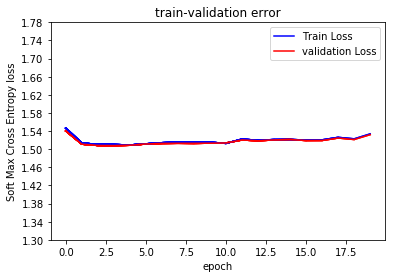

In [87]:
plt.show()

## Model 3

In [61]:
# Network Parameters
n_hidden_1 = 7 #1st hidden of 10 neurons
n_hidden_2 = 4  #2nd hidden layer of 5 neurons  
n_hidden_3 = 3  #3rd hiden layer of 3 neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

x = tf.placeholder(tf.float32, [None, 784]) # Input place holders
y_ = tf.placeholder(tf.float32, [None, 10]) # output placeholders


#initializing weights
weights_m3 = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)), # 784x10
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)),# 10x5
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.15, mean=0)),# 5x3
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes],stddev=0.120, mean=0)) # 3x10
}
biases_m3 = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),            
    'out': tf.Variable(tf.random_normal([n_classes]))              
}

# Parameters
training_epochs = 50
learning_rate = 0.01
batch_size = 100
display_step = 1

def multilayer_perceptron_m3(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'input layer:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # 1st hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # 2nd hidden layer
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b3:', biases['b3'].get_shape())        
    
    # 3rd hidden layer
    layer_3 = tf.add(tf.matmul(layer_2,weights['h3']),biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'out:', biases['out'].get_shape())   
    # Output layer with Sigmoid activation
    out_layer = tf.add(tf.matmul(layer_3, weights['out']),biases['out']) # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer


# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron_m3(x, weights_m3, biases_m3)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost_adam = 0.
        validation_avg_cost_adam = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_m2], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost_adam += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
            validation_avg_cost_adam += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(validation_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "train validation error")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "validation cost={:.9f}".format(validation_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:",100* accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

input layer: (?, 784) W[h1]: (784, 7) b[h1]: (7,)
layer_1: (?, 7) W[h2]: (7, 4) b[h2]: (4,)
layer_2: (?, 4) W[h3]: (4, 3) b3: (3,)
layer_3: (?, 3) W[out]: (3, 10) out: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=205.865863812 validation cost=205.252850754
Epoch: 0002 train cost=205.865863812 validation cost=205.252850754
Epoch: 0003 train cost=205.865863812 validation cost=205.252850754
Epoch: 0004 train cost=205.865863812 validation cost=205.252850754
Epoch: 0005 train cost=205.865863812 validation cost=205.252850754
Epoch: 0006 train cost=205.865863812 validation cost=205.252850754
Epoch: 0007 train cost=205.865863812 validation cost=205.252850754
Epoch: 0008 train cost=205.865863812 validation cost=205.252850754
Epoch: 0009 train cost=205.865863812 validation cost=205.252850754
Epoch: 0010 train cost=205.865863812 validation cost=205.252850754
Epoch: 0011 train cost=205.865863812 validation cost=205.252850754
Epoch: 0012 train cost=205.865863812 validation cost=205.252850754
Epo

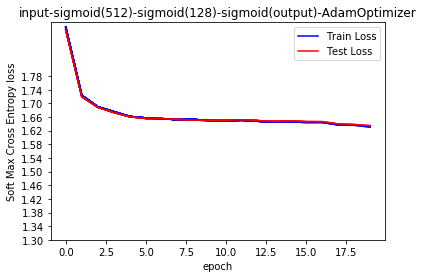

In [45]:
plt.show()

# MLP using keras

In [65]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten ,Dropout ,BatchNormalization
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [17]:
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)

x_train shape (60000, 784)
x_test shape (10000, 784)


## Model 1

In [69]:
# Model parameters
n_hidden_layer_1 = 128
n_hidden_layer_2 = 64
n_input = 784
n_output = 10
batch_size = 100
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0],n_input)
x_test = x_test.reshape(x_test.shape[0],n_input)

y_train = keras.utils.to_categorical(y_train,num_classes=n_output)
y_test = keras.utils.to_categorical(y_test, num_classes=n_output)

model = Sequential()
model.add(Dense(n_hidden_layer_1,activation='relu',input_shape=(n_input,)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.25))
model.add(Dense(n_hidden_layer_2,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_output,activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

history = model.fit(x_train, y_train,batch_size=128, epochs = epochs,validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test,verbose=0)
print(score[1]*100)


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.4118 - acc: 0.8752 - val_loss: 0.1591 - val_acc: 0.9504
Epoch 2/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.1952 - acc: 0.9408 - val_loss: 0.1206 - val_acc: 0.9642
Epoch 3/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.1514 - acc: 0.9535 - val_loss: 0.1007 - val_acc: 0.9701
Epoch 4/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.1253 - acc: 0.9617 - val_loss: 0.0902 - val_acc: 0.9730
Epoch 5/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.1089 - acc: 0.9659 - val_loss: 0.0815 - val_acc: 0.9744
Epoch 6/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.0993 - acc: 0.9689 - val_loss: 0.0817 - val_acc: 0.9751
Epoch 7/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0909 - acc: 0.9719 - val_loss: 0.0863 - val_ac

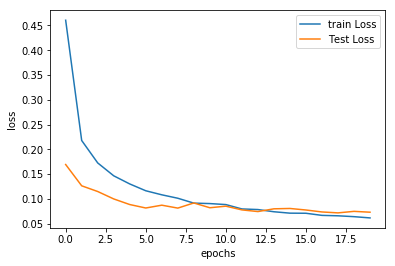

In [68]:
import numpy as np
import matplotlib.pyplot as plt
n=list(np.arange(0,20,1))

plt.plot(n,history.history['loss'],label='train Loss')
plt.plot(n,history.history['val_loss'],label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Model 2

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 124us/step - loss: 0.8186 - acc: 0.7487 - val_loss: 0.2622 - val_acc: 0.9217
Epoch 2/20
60000/60000 [==============================] - 5s 83us/step - loss: 0.3394 - acc: 0.9034 - val_loss: 0.1958 - val_acc: 0.9426
Epoch 3/20
60000/60000 [==============================] - 5s 83us/step - loss: 0.2576 - acc: 0.9286 - val_loss: 0.1638 - val_acc: 0.9534
Epoch 4/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.2094 - acc: 0.9419 - val_loss: 0.1519 - val_acc: 0.9581
Epoch 5/20
60000/60000 [==============================] - 5s 83us/step - loss: 0.1834 - acc: 0.9489 - val_loss: 0.1323 - val_acc: 0.9628
Epoch 6/20
60000/60000 [==============================] - 5s 83us/step - loss: 0.1665 - acc: 0.9543 - val_loss: 0.1313 - val_acc: 0.9610
Epoch 7/20
60000/60000 [==============================] - 5s 84us/step - loss: 0.1526 - acc: 0.9579 - val_loss: 0.1179 - val_ac

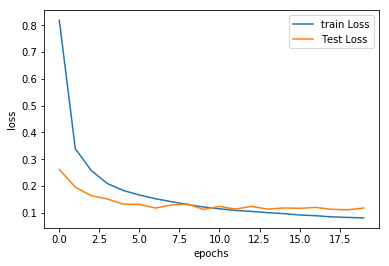

In [76]:
# model parameters

n_hidden_1 = 32
n_hidden_2 = 64
n_hidden_3 = 128
n_output = 10
n_input = 784
epochs = 20
batch_size = 128

(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],784)
x_test = x_test.reshape(x_test.shape[0],784)

y_train = keras.utils.to_categorical(y_train,num_classes=n_output)
y_test = keras.utils.to_categorical(y_test, num_classes=n_output)

model = Sequential()
model.add(Dense(n_hidden_1,activation='relu',input_shape=(784,)))
model.add(Dense(n_hidden_2,activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.5))
model.add(Dense(n_hidden_3,activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.5))
model.add(Dense(n_output,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history=model.fit(x_train, y_train,batch_size=128, epochs = epochs,validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test,verbose=0)
print(score[1]*100)
n=list(np.arange(0,20,1))

plt.plot(n,history.history['loss'],label='train Loss')
plt.plot(n,history.history['val_loss'],label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


## Model 3

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 121us/step - loss: 2.1784 - acc: 0.1664 - val_loss: 1.9464 - val_acc: 0.2103
Epoch 2/20
60000/60000 [==============================] - 4s 70us/step - loss: 1.9878 - acc: 0.1961 - val_loss: 1.8635 - val_acc: 0.2402
Epoch 3/20
60000/60000 [==============================] - 4s 69us/step - loss: 1.9131 - acc: 0.2189 - val_loss: 1.8177 - val_acc: 0.2727
Epoch 4/20
60000/60000 [==============================] - 4s 71us/step - loss: 1.8795 - acc: 0.2381 - val_loss: 1.7692 - val_acc: 0.3112
Epoch 5/20
60000/60000 [==============================] - 4s 69us/step - loss: 1.8278 - acc: 0.2618 - val_loss: 1.7789 - val_acc: 0.2942
Epoch 6/20
60000/60000 [==============================] - 4s 70us/step - loss: 1.7677 - acc: 0.2778 - val_loss: 1.5821 - val_acc: 0.3336
Epoch 7/20
60000/60000 [==============================] - 4s 70us/step - loss: 1.7349 - acc: 0.2834 - val_loss: 1.5306 - val_ac

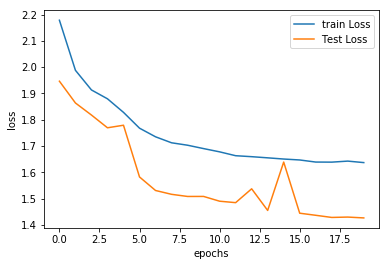

In [78]:
n_hidden_1 = 2
n_hidden_2 = 64
n_hidden_3 = 5
n_hidden_4 = 10
n_hidden_5 =2
n_output = 10
n_input = 784
epochs = 20
batch_size = 128

(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],784)
x_test = x_test.reshape(x_test.shape[0],784)

y_train = keras.utils.to_categorical(y_train,num_classes=n_output)
y_test = keras.utils.to_categorical(y_test, num_classes=n_output)

model = Sequential()
model.add(Dense(n_hidden_1,activation='relu',input_shape=(784,)))
model.add(Dense(n_hidden_2,activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.5))
model.add(Dense(n_hidden_3,activation='relu'))
model.add(Dense(n_hidden_4,activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.6))
model.add(Dense(n_hidden_5,activation='relu'))
model.add(BatchNormalization(momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones'))
model.add(Dropout(0.2))
model.add(Dense(n_output,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
history=model.fit(x_train, y_train,batch_size=128, epochs = epochs,validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test,verbose=0)
print(score[1]*100)

n=list(np.arange(0,20,1))

plt.plot(n,history.history['loss'],label='train Loss')
plt.plot(n,history.history['val_loss'],label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
